**Курсовой проект "Библиотеки Python для Data Science"**

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as  sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, GridSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [4]:
TRAIN_DATASET_PATH = '../Python_YF/train1.csv'
TEST_DATASET_PATH = '../Python_YF/test1.csv'

### Загрузка данных

Описание датасета

Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [6]:
train_df.shape

(10000, 20)

Приведение типов

In [7]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Приведем к строковым данным столбцы Id и DistrictId, т.к. они не должны участвовать в построении модели

In [8]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

Познакомимся с целевой переменной

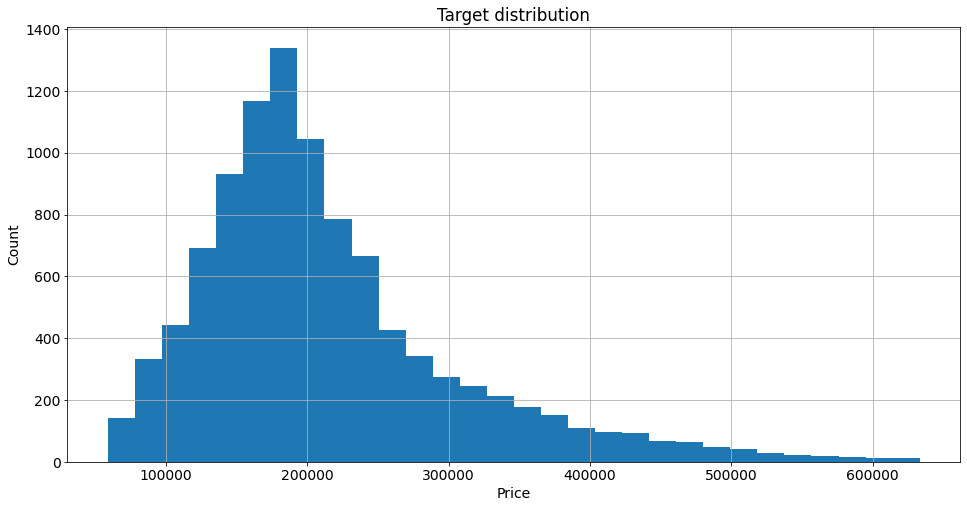

In [9]:
plt.figure(figsize = (16, 8))
train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

Количественные переменные

In [10]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Номинативные переменные

In [11]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [12]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [13]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [14]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [15]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

2. Обработка выбросов

In [16]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Здесь видно, что есть выбросы: 0, 6, 10, 19 комнат. Где 0 - это скорее всего однокомнатные, остальные помети средним значение

In [17]:
train_df['Outlier_Rooms'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Outlier_Rooms'] = 1
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Outlier_Rooms
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,...,B,35,5776,1,2078.0,2,4,B,161044.944138,0
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,...,B,24,4860,1,80.0,0,3,B,142402.739272,0
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,...,B,37,7687,11,176.0,5,5,B,326174.175191,0
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,160400.401732,0
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,...,B,5,1564,0,540.0,0,0,B,194756.023945,0


In [18]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [19]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [20]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Outlier_Rooms
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.001200
std,0.811438,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.034622
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000
max,5.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000


In [21]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [22]:
train_df['KitchenSquare'].quantile(0.975)

13.0

In [23]:
train_df['KitchenSquare'].quantile(0.025)

0.0

Возьмём минимальное значение исходят из адекватной логики - 3 кв.м.

In [24]:
condition = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(0.975))
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [25]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

In [26]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [27]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [28]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

1825 объектов, где этаж превышает количество этажей в доме

In [29]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [30]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [31]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [32]:
train_df.loc[floor_outliers, 'Floor'] = train_df['HouseFloor'].apply(lambda x: random.randint(1, x))

In [33]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

In [34]:
train_df['HouseYear'].sort_values(ascending = False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [35]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

Обработка пропусков

In [36]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Outlier_Rooms            0
HouseFloor_outlier       0
dtype: int64

LifeSquare. Вычтем из общей площади площадь кухни и площад на санузел и коридор (примерно 3 кв.м.)

In [37]:
train_df['LifeSquare_Nan'] = train_df['LifeSquare'].isna() * 1

In [38]:
condition = (train_df['LifeSquare'].isna()) | (~train_df['KitchenSquare'].isna()) | (~train_df['Square'].isna())
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] - 3

Healthcare_1

In [39]:
train_df['Healthcare_1'].value_counts()

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

In [40]:
train_df['Healthcare_1'].describe()

count    5202.000000
mean     1142.904460
std      1021.517264
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [41]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [42]:
train_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Outlier_Rooms         0
HouseFloor_outlier    0
LifeSquare_Nan        0
dtype: int64

Построение новых признаков

In [43]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Outlier_Rooms,HouseFloor_outlier,LifeSquare_Nan
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,56.315775,47.077575,6.238200,7.380400,12.95910,1984.872400,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.001200,0.182500,0.211300
std,0.811438,21.058732,21.036163,2.794717,5.036887,6.44346,18.416347,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.034622,0.386275,0.408251
min,1.000000,1.136859,-4.863141,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,1.000000,41.774881,32.697526,3.000000,3.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000
50%,2.000000,52.513310,42.741735,6.000000,6.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000
75%,2.000000,65.900625,57.993718,8.000000,10.250000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000
max,5.000000,641.065193,628.065193,13.000000,42.000000,117.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


In [44]:
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Outlier_Rooms,HouseFloor_outlier,LifeSquare_Nan
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,3097,0,900.0,0,0,B,305018.871089,0,0,1
1,3013,22,1.0,39.832524,28.832524,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.553407,0,0,0
2,8215,1,3.0,78.342215,65.342215,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.720850,0,0,0
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,264,0,900.0,0,1,B,168106.007630,0,0,1
4,13866,94,2.0,64.285067,52.285067,9.0,16,16.0,1972,0.282798,...,8667,2,900.0,0,6,B,343995.102962,0,0,0
5,5804,99,3.0,62.528465,53.528465,6.0,9,9.0,1972,0.012339,...,5776,1,2078.0,2,4,B,161044.944138,0,0,0
6,8864,44,1.0,33.938750,21.938750,9.0,1,12.0,1968,0.232205,...,4860,1,80.0,0,3,B,142402.739272,0,0,0
7,13072,59,2.0,50.391814,39.391814,8.0,8,17.0,1986,0.019509,...,7687,11,176.0,5,5,B,326174.175191,0,0,0
8,9951,1,1.0,46.887892,40.887892,3.0,12,20.0,1977,0.007122,...,264,0,900.0,0,1,B,160400.401732,0,0,0
9,8094,6,3.0,79.867477,73.867477,3.0,3,17.0,2014,0.243205,...,1564,0,540.0,0,0,B,194756.023945,0,0,0


In [45]:
train_df['Ecology_1'].sort_values()

1612    0.000000
8449    0.000000
9204    0.000000
810     0.000000
7719    0.000000
          ...   
6140    0.521867
9347    0.521867
8435    0.521867
2495    0.521867
7450    0.521867
Name: Ecology_1, Length: 10000, dtype: float64

In [46]:
train_df['Ecology_1'].describe()

count    10000.000000
mean         0.118858
std          0.119025
min          0.000000
25%          0.017647
50%          0.075424
75%          0.195781
max          0.521867
Name: Ecology_1, dtype: float64

In [47]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [48]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

Признак Ecology_1 является вещественным, можно сделать из него категориальную фичу

In [49]:
def Ecology_1_to_cat(X):
    bins = [X['Ecology_1'].min(), 0.25, 0.35, X['Ecology_1'].max()]
    X['Ecology_1_cat'] = pd.cut(X['Ecology_1'], bins=bins, labels=False)
    X['Ecology_1_cat'].fillna(-1, inplace=True)
    return X

In [50]:
Ecology_1_to_cat(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Outlier_Rooms,HouseFloor_outlier,LifeSquare_Nan,Ecology_1_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,900.0,0,0,B,305018.871089,0,0,1,0.0
1,3013,22,1.0,39.832524,28.832524,8.0,7,8.0,1966,0.118537,...,1,1183.0,1,0,B,177734.553407,0,0,0,0.0
2,8215,1,3.0,78.342215,65.342215,10.0,2,17.0,1988,0.025609,...,0,240.0,3,1,B,282078.720850,0,0,0,0.0
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,900.0,0,1,B,168106.007630,0,0,1,0.0
4,13866,94,2.0,64.285067,52.285067,9.0,16,16.0,1972,0.282798,...,2,900.0,0,6,B,343995.102962,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,40.090728,6.0,3,12.0,1981,0.300323,...,6,900.0,1,9,B,119367.455796,0,0,0,1.0
9996,16265,27,2.0,64.307684,52.307684,9.0,13,13.0,1977,0.072158,...,1,900.0,0,0,A,199715.148807,0,1,0,0.0
9997,2795,178,1.0,29.648057,21.648057,5.0,3,5.0,1958,0.460556,...,14,900.0,1,5,B,165953.912580,0,0,0,2.0
9998,14561,21,1.0,32.330292,24.330292,5.0,3,9.0,1969,0.194489,...,3,125.0,3,5,B,171842.411855,0,0,0,0.0


Построение новых признаков

Признаки Ecology_2 и Ecology_3 сделаем дамми

In [51]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)

In [52]:
binary_to_numbers = {'A': 0, 'B': 1}
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

Категориальный признак DistrictId переведём в вещественный по его частотности.

In [53]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
.rename(columns={'index':'DistrictId', 'DistrictId':'district_size'})
district_size.head()

,DistrictId,district_size
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [54]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Outlier_Rooms,HouseFloor_outlier,LifeSquare_Nan,Ecology_1_cat,district_size
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,900.0,0,0,1,305018.871089,0,0,1,0.0,851
1,3013,22,1.0,39.832524,28.832524,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,1,177734.553407,0,0,0,0.0,78
2,8215,1,3.0,78.342215,65.342215,10.0,2,17.0,1988,0.025609,...,240.0,3,1,1,282078.720850,0,0,0,0.0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,900.0,0,1,1,168106.007630,0,0,1,0.0,652
4,13866,94,2.0,64.285067,52.285067,9.0,16,16.0,1972,0.282798,...,900.0,0,6,1,343995.102962,0,0,0,1.0,89


Создадим новый признак, используя метод Target Encoding.

Самое очевидное из-за чего может изменяться стоимость квартиры - это район расположения DistrictId и количество комнат Rooms

In [55]:
med_price_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                    .rename(columns={'Price':'medPriceDistrict'})
med_price_district.head()

,DistrictId,Rooms,medPriceDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [56]:
train_df = train_df.merge(med_price_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Outlier_Rooms,HouseFloor_outlier,LifeSquare_Nan,Ecology_1_cat,district_size,medPriceDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,1,0.0,851,213530.788443
1,3013,22,1.0,39.832524,28.832524,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,0.0,78,146032.829834
2,8215,1,3.0,78.342215,65.342215,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,0.0,652,244005.272380
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,0,0,1,0.0,652,146735.671740
4,13866,94,2.0,64.285067,52.285067,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,1.0,89,201584.441255


Отбор признаков

In [57]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Outlier_Rooms',
 'HouseFloor_outlier',
 'LifeSquare_Nan',
 'Ecology_1_cat',
 'district_size',
 'medPriceDistrict']

Оставим всё, кроме 'Id', 'DistrictId'

In [58]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Outlier_Rooms', 'HouseFloor_outlier', 'LifeSquare_Nan', 'district_size',
                     'medPriceDistrict']

target_name = 'Price'

Разбиение на train и test

In [59]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [60]:
y.head()

0    305018.871089
1    177734.553407
2    282078.720850
3    168106.007630
4    343995.102962
Name: Price, dtype: float64

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

Построение модели  Gradient Boosting decision trees

Train R2:	0.832
Test R2:	0.75


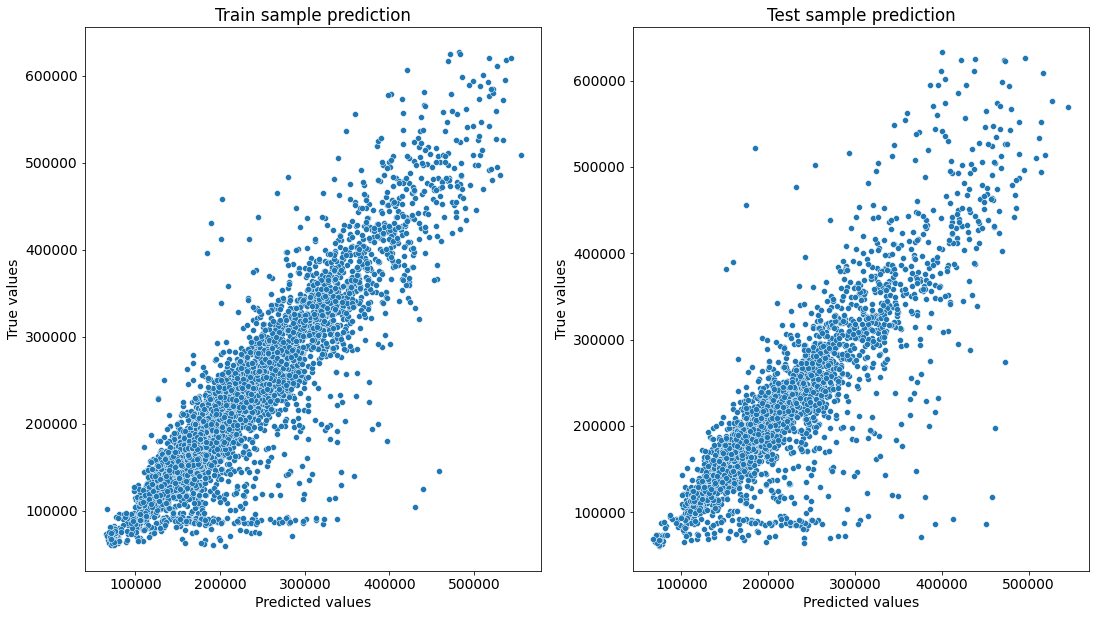

In [62]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Кросс-валидация

In [63]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72468034, 0.76257816, 0.75709831])

Важность признаков

In [64]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
24,medPriceDistrict,0.733567
3,Square,0.096646
23,district_size,0.022237
8,HouseYear,0.020639
14,Social_3,0.019432
5,KitchenSquare,0.019151
4,LifeSquare,0.018006
7,HouseFloor,0.010949
12,Social_1,0.009951
13,Social_2,0.009662


Признак medPriceDistrict имеет слишком сильное влияние на модель и поэтому происходит переобучение. Уберем его из модели

In [65]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Outlier_Rooms', 'HouseFloor_outlier', 'LifeSquare_Nan', 'district_size']

target_name = 'Price'

In [66]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

Train R2:	0.806
Test R2:	0.749


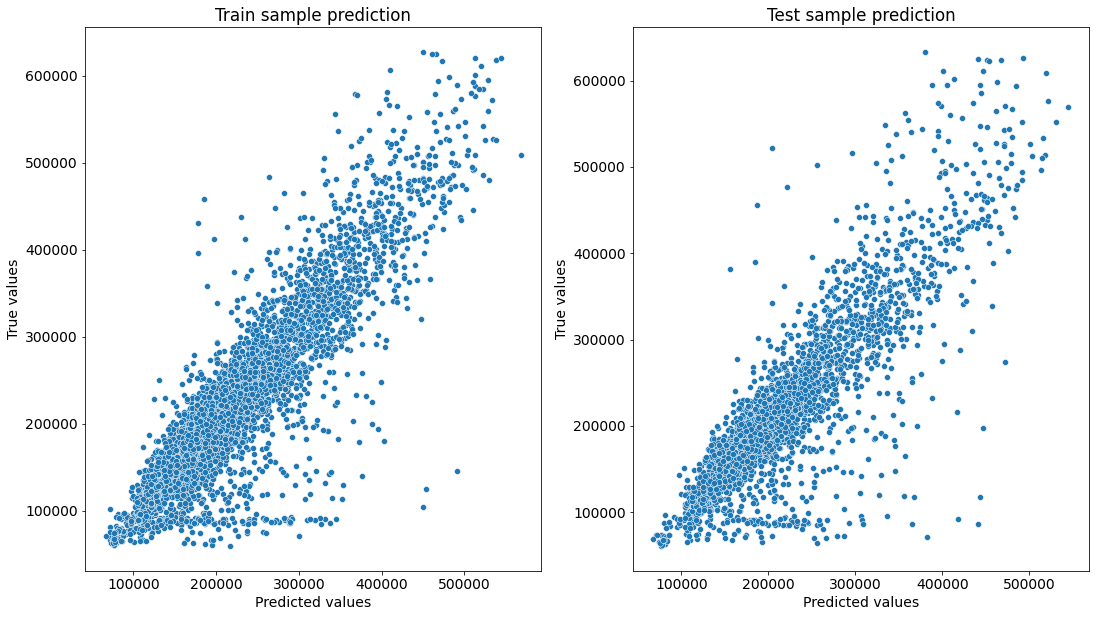

In [68]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=4,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Прогнозирование на тестовом датасете

In [69]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [70]:
test_df.shape

(5000, 19)

Проделаем тоже самое с тестовым датасетом

Номинативные переменные

In [71]:
test_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [72]:
test_df['Ecology_2'].value_counts()
test_df['Ecology_3'].value_counts()
test_df['Shops_2'].value_counts()

B    4588
A     412
Name: Shops_2, dtype: int64

Обработка выбросов

In [73]:
test_df['Outlier_Rooms'] = 0
test_df.loc[(train_df['Rooms'] == 0) | (test_df['Rooms'] >= 6), 'Outlier_Rooms'] = 1

In [74]:
test_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
test_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = test_df['Rooms'].median()

In [75]:
condition = (train_df['KitchenSquare'].isna()) | (test_df['KitchenSquare'] > test_df['KitchenSquare'].quantile(0.975))
test_df.loc[condition, 'KitchenSquare'] = test_df['KitchenSquare'].median()
test_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [76]:
test_df['HouseFloor_outlier'] = 0
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
test_df.loc[test_df['Floor'] > test_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [77]:
test_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

In [78]:
floor_outliers = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index
floor_outliers

Int64Index([  11,   12,   14,   21,   22,   25,   26,   42,   46,   47,
            ...
            4951, 4952, 4960, 4971, 4973, 4976, 4978, 4980, 4982, 4995],
           dtype='int64', length=884)

In [79]:
test_df.loc[floor_outliers, 'Floor'] = test_df['HouseFloor'].min()

In [80]:
test_df.loc[test_df['HouseYear'] > 2020, 'HouseYear'] = 2020

Обработка пропусков

In [81]:
test_df['LifeSquare_Nan'] = test_df['LifeSquare'].isna() * 1

In [82]:
condition = (test_df['LifeSquare'].isna()) | (~test_df['KitchenSquare'].isna()) | (~test_df['Square'].isna())
test_df.loc[condition, 'LifeSquare'] = test_df.loc[condition, 'Square'] - test_df.loc[condition, 'KitchenSquare'] - 3

In [83]:
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

In [84]:
test_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Outlier_Rooms         0
HouseFloor_outlier    0
LifeSquare_Nan        0
dtype: int64

In [85]:
def Ecology_1_to_cat(X):
    bins = [X['Ecology_1'].min(), 0.25, 0.35, X['Ecology_1'].max()]
    X['Ecology_1_cat'] = pd.cut(X['Ecology_1'], bins=bins, labels=False)
    X['Ecology_1_cat'].fillna(-1, inplace=True)
    return X

In [86]:
binary_to_numbers = {'A': 0, 'B': 1}

test_df['Ecology_2'] = test_df['Ecology_2'].replace(binary_to_numbers)
test_df['Ecology_3'] = test_df['Ecology_3'].replace(binary_to_numbers)
test_df['Shops_2'] = test_df['Shops_2'].replace(binary_to_numbers)

In [87]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Outlier_Rooms', 'HouseFloor_outlier', 'LifeSquare_Nan', 'district_size']

target_name = 'Price'

In [103]:
submit = pd.read_csv('../Python_YF/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [89]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Outlier_Rooms,HouseFloor_outlier,LifeSquare_Nan
0,4567,44,1.0,36.847630,28.847630,5.0,5,9.0,1970,0.036122,...,24,4378,0,1036.0,1,1,1,0,0,0
1,5925,62,1.0,42.493907,29.493907,10.0,7,17.0,2017,0.072158,...,2,629,1,900.0,0,0,0,0,0,0
2,960,27,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,...,9,1892,0,900.0,0,1,1,0,0,1
3,3848,23,3.0,49.646030,40.646030,6.0,2,2.0,1965,0.014073,...,2,475,0,900.0,0,0,1,0,0,0
4,746,74,1.0,53.837056,49.837056,1.0,8,17.0,1977,0.309479,...,35,7715,4,990.0,0,6,1,0,0,1


In [104]:
predictions = gb_model.predict(test_df)
predictions

array([163329.96948851, 129291.77977026, 157208.53001567, ...,
       149395.29498088, 183979.14588557, 248647.81759819])

In [105]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163329.969489
1,5925,129291.779770
2,960,157208.530016
3,3848,141688.673354
4,746,196710.782662


In [107]:
submit.to_csv('gb_submit.csv', index=False)